<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# 2 Convolutional Neural Networks

## 2.0 Import libraries

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from skimage import io
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the datasets folder (should be in shared/datasets/mnist)
datasets_dir = os.path.join(path, '..', 'shared', 'datasets', 'mnist')

# Set the directory to the data folder (should be in ML-LV/data/digits)
data_dir = os.path.join(path, 'data', 'digits')

## 2.1 Load and pre-process data

1. First load the full MNIST dataset by using the Keras function.

2. Then load our MNIST digits as a test set.

3. The next cell plots the distribution of the digits between the training and validation sets.

Number of training images = 60000
Number of validation images = 10000
Number of testing images = 10
Shape of the training images = (60000, 28, 28)


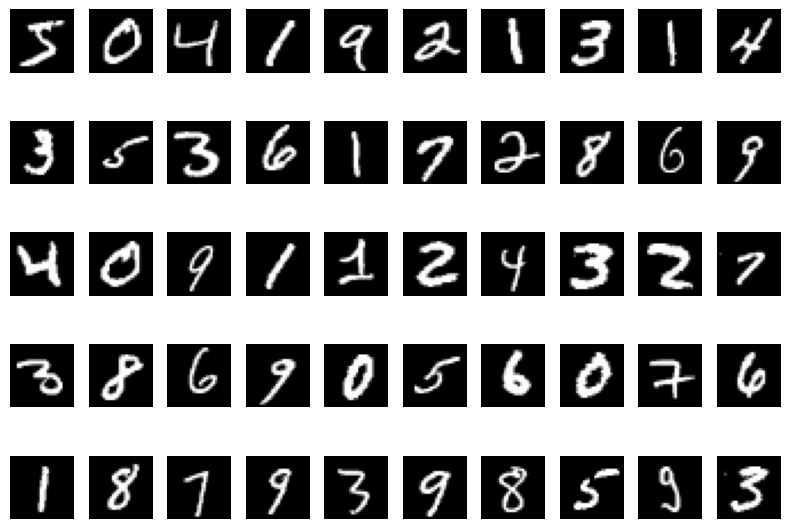

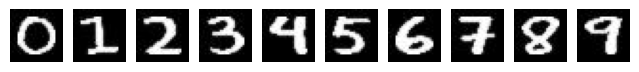

In [3]:
# Load the MNIST dataset
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data(path=os.path.join(datasets_dir, 'mnist.npz'))

# Load your own handwritten digits
X_test = np.empty((10, 28, 28), dtype=np.uint8)
for i in range(10):
    X_test[i] = io.imread(os.path.join(data_dir, 'my_digits_mnist', f'digit_{i}.jpg'))
y_test = np.arange(10)

# Display the number and shape of the images
print(f"Number of training images = {len(X_train)}")
print(f"Number of validation images = {len(X_val)}")
print(f"Number of testing images = {len(X_test)}")
print(f"Shape of the training images = {X_train.shape}")

# Display some digits
fig, ax = plt.subplots(5, 10, figsize=(8, 6))
ax = ax.ravel()
for i in range(50):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].axis('off')
fig.tight_layout()
plt.show()

# Display your digits
fig, ax = plt.subplots(1, 10, figsize=(8, 6))
for i in range(10):
    ax[i].imshow(X_test[i], cmap='gray')
    ax[i].axis('off')
plt.show()

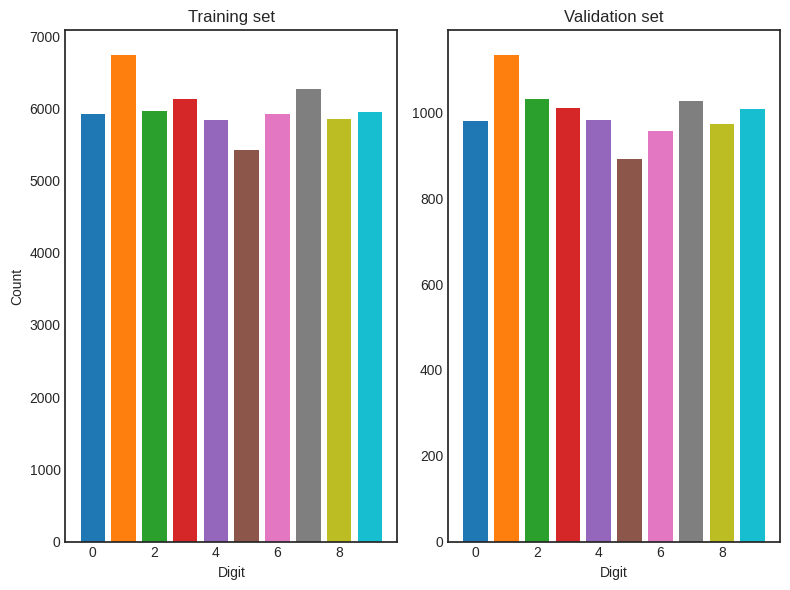

In [4]:
# Display the distribution of the digits
cmap = plt.get_cmap('tab10')
colours = cmap(np.unique(y_train)/10)
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].bar(np.unique(y_train), np.unique(y_train, return_counts=True)[1], color=colours)
ax[0].set_title('Training set')
ax[0].set_xlabel('Digit')
ax[0].set_ylabel('Count')
ax[1].bar(np.unique(y_val), np.unique(y_val, return_counts=True)[1], color=colours)
ax[1].set_title('Validation set')
ax[1].set_xlabel('Digit')
plt.tight_layout()
plt.show()

### Create the pre-processing pipeline

Notice that with CNNs we no longer need  to flatten the images! However, we do need to add a final channel dimension. In this case our images are greyscale so we just add single dimension to the end of the image array.

In [5]:
# Define the pre-processing layers
processing_pipeline = tf.keras.Sequential([
    layers.Rescaling(1./255), # Normalise pixel values to the [0, 1] range
    layers.Lambda(lambda x: tf.reshape(x, (-1, x.shape[1], x.shape[2], 1))) # Custom layer to reshape the images
], name='mnist_preprocessing')

print(f"Shape before pre-processing = {X_train.shape}")
X_train_processed = processing_pipeline(X_train)
print(f"Shape after pre-processing = {X_train_processed.shape}")

Shape before pre-processing = (60000, 28, 28)
Shape after pre-processing = (60000, 28, 28, 1)


## 2.2 Convolutional Neural Network

The CNN model comprises two sets of convolution and pooling layers before flattening their output and performing classification.

Parameters for the convolutional ([Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)) layers:
- `filters` the number of filters (Kernels) to pass over the image. In this case 8 in both convolutional layers.

- `kernel_size` the dimensions of each filter. In this case 5x5 and 3x3.

- `padding` the type of padding to use. Either 'same', which maintains the input dimension or 'valid', which means no padding.

Parameters for the pooling ([MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) layers:

- `pool_size` the dimensions of window size. In this case 2x2.

- `padding` the type of padding to use. Either 'same', which maintains the input dimension or 'valid', which means no padding.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

Finally two fully-connected (Dense) layers with dropout in between. The last layer outputs distribution of probability of each class.

In [6]:
# Input layer takes an image of size 28x28
inputs = layers.Input(shape=(28, 28, ), name='input')

# Pass the image through the pre-processing pipeline
x = processing_pipeline(inputs)

# First convolutional layer with 8 filters of size 5x5, followed by max pooling
x = layers.Conv2D(filters=8, kernel_size=(5, 5), padding='same', activation='relu', name='conv_1')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_1')(x)

# Second convolutional layer with 8 filters of size 3x3, followed by max pooling
x = layers.Conv2D(filters=8, kernel_size=(3, 3),  padding='same', activation='relu', name='conv_2')(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool_2')(x)

# Flatten the output of the convolutional layers
x = layers.Flatten()(x)

# Classification layers with 100, and 10 neurons respectively
x = layers.Dense(100, activation='relu', name='dense_1')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax', name='output')(x)

# Compile the model
model = models.Model(inputs=inputs, outputs=outputs,  name='mnist_model')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_preprocessing             │ (None, 28, 28, 1)      │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 28, 28, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        39,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,102 (160.55 KB)

 Trainable params: 41,102 (160.55 KB)

 Non-trainable params: 0 (0.00 B)

### Train and evaluate the model

In [7]:
if not grading:
    model_earlystp = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=5,
        verbose=0,
        mode="min",
        restore_best_weights=True)

    # Fit the model
    results = model.fit(X_train, y_train, epochs=50, batch_size=1000, validation_data=(X_val, y_val), callbacks=[model_earlystp], verbose=2)

Epoch 1/50
60/60 - 11s - 175ms/step - accuracy: 0.5846 - loss: 1.3177 - val_accuracy: 0.8908 - val_loss: 0.4028
Epoch 2/50
60/60 - 9s - 146ms/step - accuracy: 0.8652 - loss: 0.4384 - val_accuracy: 0.9356 - val_loss: 0.2159
Epoch 3/50
60/60 - 9s - 144ms/step - accuracy: 0.9105 - loss: 0.2968 - val_accuracy: 0.9520 - val_loss: 0.1529
Epoch 4/50
60/60 - 9s - 146ms/step - accuracy: 0.9315 - loss: 0.2320 - val_accuracy: 0.9626 - val_loss: 0.1180
Epoch 5/50
60/60 - 9s - 145ms/step - accuracy: 0.9419 - loss: 0.1964 - val_accuracy: 0.9693 - val_loss: 0.0970
Epoch 6/50
60/60 - 10s - 169ms/step - accuracy: 0.9507 - loss: 0.1674 - val_accuracy: 0.9720 - val_loss: 0.0841
Epoch 7/50
60/60 - 9s - 145ms/step - accuracy: 0.9552 - loss: 0.1516 - val_accuracy: 0.9742 - val_loss: 0.0749
Epoch 8/50
60/60 - 9s - 146ms/step - accuracy: 0.9585 - loss: 0.1390 - val_accuracy: 0.9758 - val_loss: 0.0739
Epoch 9/50
60/60 - 9s - 147ms/step - accuracy: 0.9623 - loss: 0.1287 - val_accuracy: 0.9788 - val_loss: 0.0628

Train loss: 0.055
Train accuracy: 0.984
Best validation loss: 0.032
Best validation accuracy: 0.990


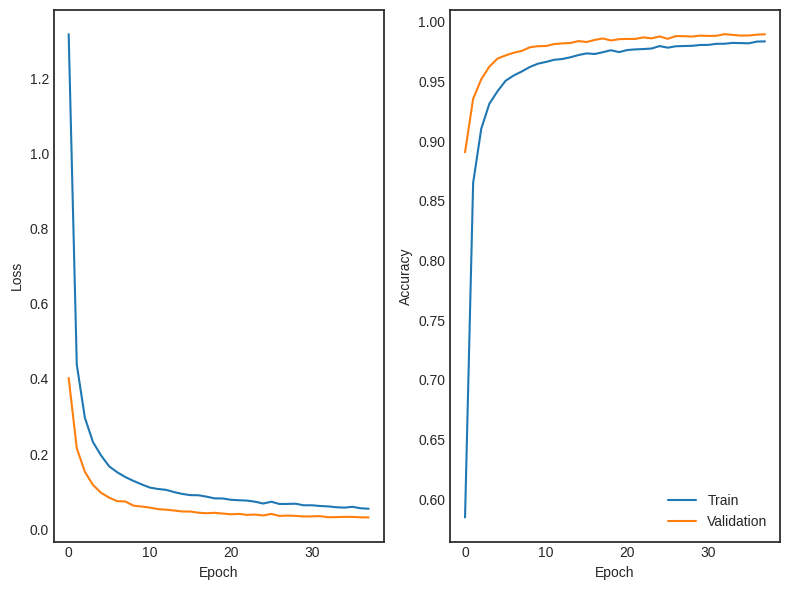

In [8]:
if not grading:
    # Show best loss and accuracy
    metrics = results.history
    print(f"Train loss: {min(metrics['loss']):.3f}")
    print(f"Train accuracy: {max(metrics['accuracy']):.3f}")
    print(f"Best validation loss: {min(metrics['val_loss']):.3f}")
    print(f"Best validation accuracy: {max(metrics['val_accuracy']):.3f}")

    # Plot the training loss and accuracy
    fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=False)
    ax[0].plot(metrics['loss'], label='Train Loss')
    ax[0].plot(metrics['val_loss'], label='Validation Loss')
    ax[0].set(xlabel='Epoch', ylabel='Loss')
    ax[1].plot(metrics['accuracy'], label='Train Accuracy')
    ax[1].plot(metrics['val_accuracy'], label='Validation Accuracy')
    ax[1].set(xlabel='Epoch', ylabel='Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.show()

### Evaluate the model on your MNIST digits

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Test Accuracy: 0.9


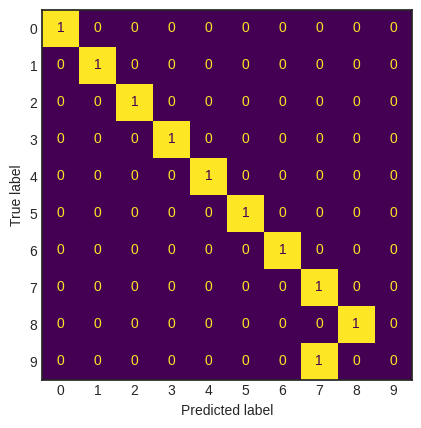

In [8]:
if not grading:
    # Predict class labels for test set
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)
    print(f'Test Accuracy: {accuracy_score(y_test, predictions)}')

    # Print confusion matrix
    conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, predictions, colorbar=False)
    plt.show()

### Plot model weights

With a trained CNN we can plot the activations of each convolutional and subsequent pooling layers, similar to the 10 node perceptron from the last tutorial.

First we will select 10 of each digit to observe the different activations.

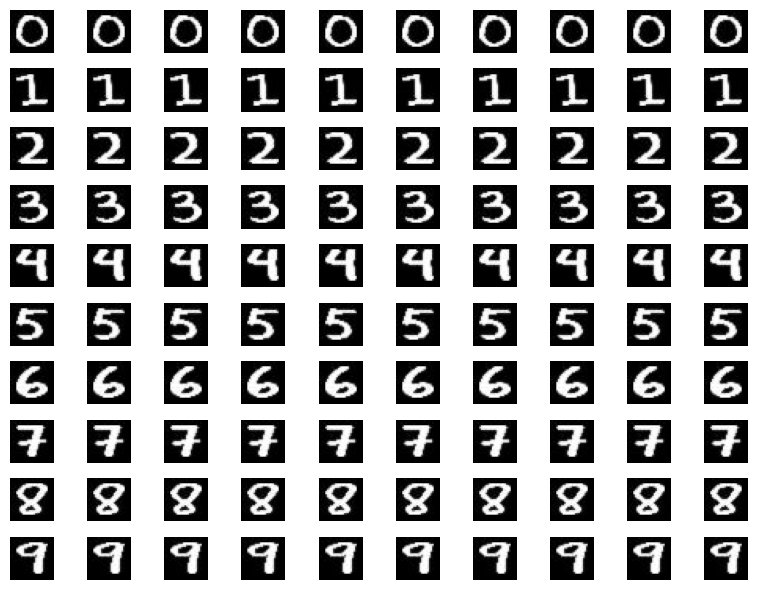

In [9]:
# Randomly select 10 images of each digit
X_rand_digits = []
for digit in range(10):
    digit_indexes = np.where(y_test == digit)[0]
    rand_index = np.random.choice(digit_indexes, 10)
    digit_img = X_test[rand_index]
    X_rand_digits.extend(digit_img)
X_rand_digits = np.array(X_rand_digits)

# Plot the images
fig, ax = plt.subplots(10, 10, figsize=(8, 6))
ax = ax.ravel()
for i in range(len(X_rand_digits)):
    ax[i].imshow(X_rand_digits[i], cmap='gray')
    ax[i].axis('off')
fig.tight_layout()
plt.show()

Create an 'activation model' that returns the outputs of each layer instead of predictions. Also, select only the convolutional and pooling layers activations.

In [10]:
# Select only the convolutional layers onwards
layer_outputs = [layer.output for layer in model.layers[2:]]
# Create the activation model
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs)
print(activation_model.summary())

# Get the activations of the convolutional layers
activations = activation_model.predict(X_rand_digits)

# Store layer names and activation sizes
layer_names = []
layer_sizes = []

for i in range(len(activations)):
    layer = activation_model.layers[i + 2]
    if len(activations[i].shape) == 4:
        layer_names.append(layer.name)
        layer_sizes.append(activations[i].shape)
print(f"Selected layers: \n{layer_names}\n{layer_sizes}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mnist_preprocessing             │ (None, 28, 28, 1)      │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 28, 28, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        39,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,102 (160.55 KB)

 Trainable params: 41,102 (160.55 KB)

 Non-trainable params: 0 (0.00 B)

None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Selected layers: 
['conv_1', 'pool_1', 'conv_2', 'pool_2']
[(100, 28, 28, 8), (100, 14, 14, 8), (100, 14, 14, 8), (100, 7, 7, 8)]


Plot the convolutional and pooling layers activations for each of the 100 input digits.

In [2]:
# if not grading:
#     # Plot the activations of the convolutional layers
#     columns = layer_sizes[0][3]  # Number of filters in the convolutional layers
#     rows = len(layer_names) + 1  # Add one for the input image

#     fig, ax = plt.subplots(rows, columns, figsize=(8, 6))

#     # Set the first row to the input image
#     num_ax = ax[0, 0].imshow(X_rand_digits[0], cmap='viridis', animated=True)
#     # Set title for the first row
#     ax[0, 0].set_ylabel('Input', loc='center', rotation='horizontal', fontsize=10, labelpad=20)
#     # Make x_axis invisible
#     ax[0, 0].xaxis.set_visible(False)
#     # Make spines (the box) invisible
#     plt.setp(ax[0, 0].spines.values(), visible=False)
#     # Remove ticks and labels for the left axis
#     ax[0, 0].tick_params(left=False, labelleft=False)

#     # Remove the axes for the rest of the images on the first row
#     for i in range(1, columns):
#             ax[0, i].axis('off')

#     # Set the rest of the rows to the activations of the convolutional layers
#     filter_ax = np.empty((rows-1, columns), dtype=object)
#     for row in range(1, rows):
#         for col in range(columns):
#             filter_ax[row-1][col] = ax[row, col].imshow(activations[row-1][0, :, :, col], cmap='viridis', animated=True)

#             # Set the title for the row
#             if col == 0:
#                 ax[row, col].set_ylabel(layer_names[row-1].replace('_', ' '), loc='center', rotation='horizontal', fontsize=10, labelpad=20)
#                 # Make x_axis invisible
#                 ax[row, col].xaxis.set_visible(False)
#                 # Make spines (the box) invisible
#                 plt.setp(ax[row, col].spines.values(), visible=False)
#                 # Remove ticks and labels for the left axis
#                 ax[row, col].tick_params(left=False, labelleft=False)
#             else:
#                 ax[row, col].axis('off')

#     # Define the animation function
#     def animate_activation(i):
#         # Set the current digit image
#         num_ax.set_data(X_rand_digits[i])
        
#         # Update the activations of the convolutional layers
#         for row in range(1, rows):
#             for col in range(columns):
#                 filter_ax[row-1][col].set_data(activations[row-1][i, :, :, col])

#     # Create the animation
#     anim = FuncAnimation(fig, animate_activation, frames=activations[0].shape[0], interval=500, repeat=True, repeat_delay=1000, blit=False)
#     html = HTML(anim.to_jshtml())
#     display(html)
#     plt.close()

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280